In [ ]:
#import library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1 - Load and observe the dataset

In [ ]:
#assign the names to each columns
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
    'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
    'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label','difficulty_level'
]
#load the dataset and observe the first 10 rows
dataset=pd.read_csv(r"C:\Users\amity\SentinelNet\data\NSL-KDD\KDDTrain+.txt", header=None, names=columns)
dataset.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
9,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


In [16]:
#finding the number of rows and columns in the dataset
dataset.shape

(125973, 43)

# data Cleaning 

In [27]:
#finding the null values
# dataset.isnull() #shows Nan if null value found else false
# dataset.isnull().sum() #no of null values in each column
dataset.isnull().sum().sum() #total no of null values in each column

np.int64(0)

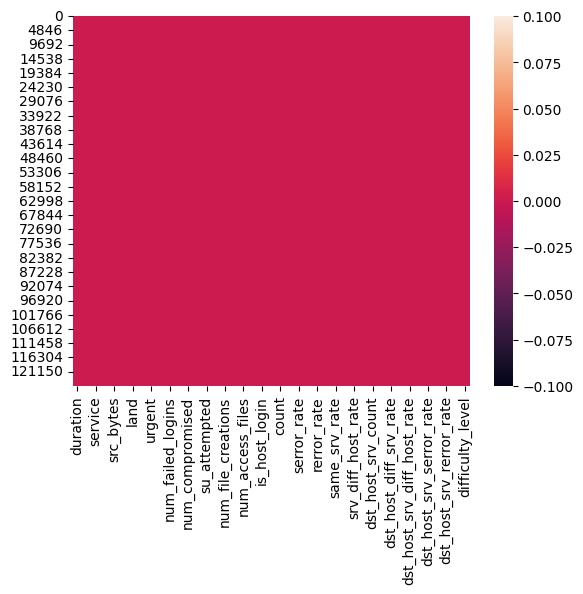

In [ ]:
#Graphcally representation of the missing values...misssing=true--towards 1 else towars 1
sns.heatmap(dataset.isnull())
plt.show()

In [29]:
#Check Duplicates
duplicates = dataset.duplicated().sum()
print("Number of duplicate rows:", duplicates)
#remove dublicates if found
if duplicates > 0:
    before = dataset.shape[0] #store the actual no of rows before removing the dublicates
    dataset.drop_duplicates(inplace=True) #remove dublicates 
    print(f"Removed {before - dataset.shape[0]} duplicates. New shape: {dataset.shape}") #print the no of dublicates found 
else:
    print("No duplicates found.")

Number of duplicate rows: 0
No duplicates found.


In [31]:
# Target  Attack_binary--Column:0 = Normal, 1=Attack

dataset['attack_binary'] = dataset['label'].apply(lambda x: 0 if x == 'normal' else 1)

print(dataset[['label','attack_binary']].head(10))  # preview labels

     label  attack_binary
0   normal              0
1   normal              0
2  neptune              1
3   normal              0
4   normal              0
5  neptune              1
6  neptune              1
7  neptune              1
8  neptune              1
9  neptune              1


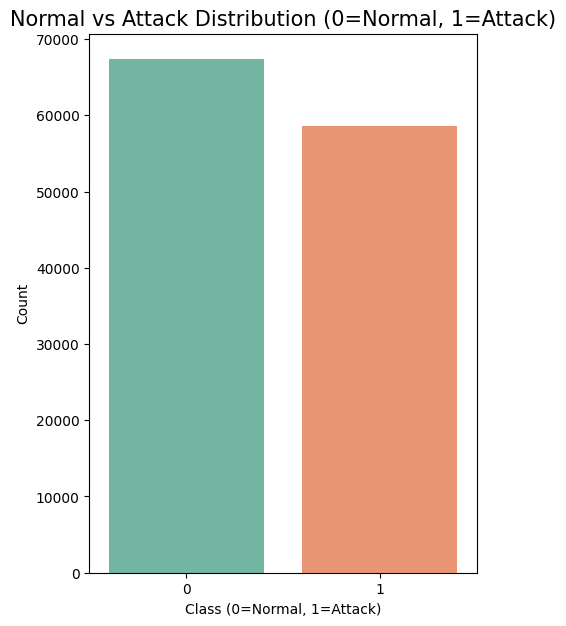

In [43]:
#EDA---for finding pattern and deciding how to process the dataset
#finding how many normal and attack connection in my dataset to check dataset is balanced or imbalanced
# Normal vs Attack distribution plot
plt.figure(figsize=(5,7))
sns.countplot(x='attack_binary', data=dataset, hue='attack_binary', palette="Set2", dodge=False, legend=False)
plt.title("Normal vs Attack Distribution (0=Normal, 1=Attack)", fontsize=15)
plt.xlabel("Class (0=Normal, 1=Attack)")
plt.ylabel("Count")
plt.show()



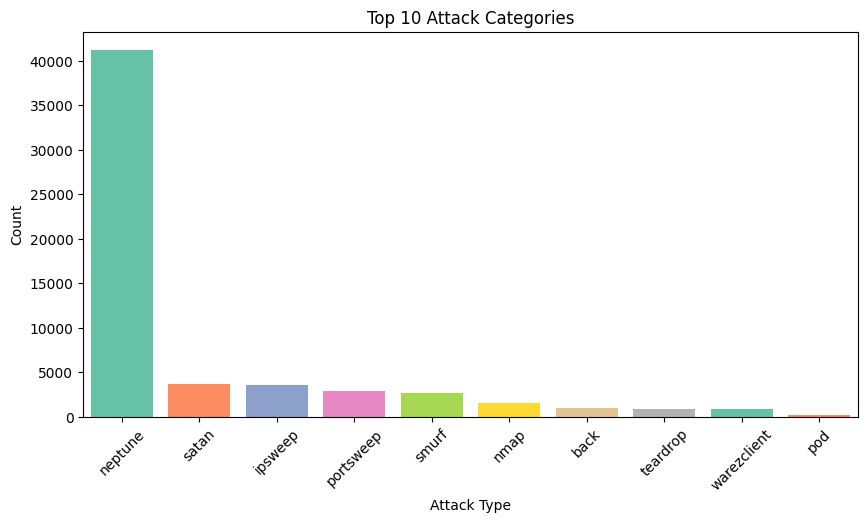

In [ ]:
#for label
#  select the top 10 attack types and count the no. of occurences but exclude normal traffic
attack_counts = dataset[dataset['label'] != 'normal']['label'].value_counts().head(10)
#show this using a bar chart
plt.figure(figsize=(10,5))
sns.barplot(x=attack_counts.index, y=attack_counts.values) 
# Generate a color palette  as the no. of colors as bars
colors = sns.color_palette("Set2", len(attack_counts))
# Apply a unique color to each bar in the chart
for i, bar in enumerate(plt.gca().patches):
    bar.set_facecolor(colors[i])
plt.title("Top 10 Attack Categories", fontsize=12)
plt.xlabel("Attack Type")
plt.ylabel("Count")
# Rotate the x-axis labels by 45 degrees so they don't overlap and are easier to read
plt.xticks(rotation=45)  
plt.show()


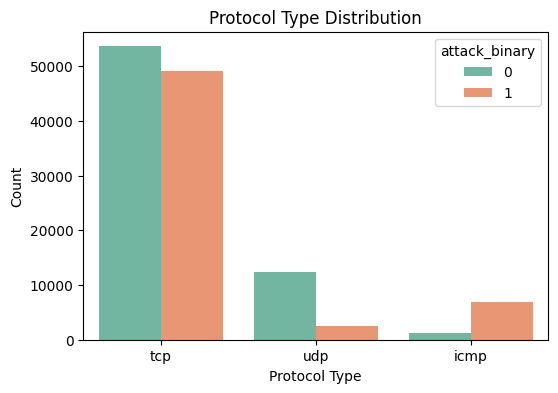

In [45]:
# Step: Protocol distribution by # for attack_binary
plt.figure(figsize=(6,4))
sns.countplot(x='protocol_type', data=dataset, hue='attack_binary', palette="Set2")
plt.title("Protocol Type Distribution", fontsize=12)
plt.xlabel("Protocol Type")
plt.ylabel("Count")
plt.show()


In [ ]:
#print all the column names
print(dataset.columns)

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=122)


In [60]:
# Step 5: One-Hot Encoding
# Select the categorical columns to encode
categorical_cols = ['protocol_type', 'service', 'flag']

# Check which of these columns exist in the dataset (avoid KeyError)
existing_cols = [col for col in categorical_cols if col in dataset.columns]

# Apply one-hot encoding only to existing categorical columns
dataset = pd.get_dummies(dataset, columns=existing_cols, drop_first=True)

# Display first 5 rows to verify
print(dataset.head())

# Check total number of columns after encoding
print("Total columns after one-hot encoding:", len(dataset.columns))


   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0        491          0     0               0       0    0   
1         0        146          0     0               0       0    0   
2         0          0          0     0               0       0    0   
3         0        232       8153     0               0       0    0   
4         0        199        420     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0                  0          0                0  ...     False      False   
1                  0          0                0  ...     False      False   
2                  0          0                0  ...     False      False   
3                  0          1                0  ...     False      False   
4                  0          1                0  ...     False      False   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
0        False      Fals

In [ ]:
#Feature Scaling: making all the numbers in our dataset on the same scale so that machine learning models can learn better and faster.
#exclude the non numeric features
from sklearn.preprocessing import MinMaxScaler

# Columns we don’t want to scale
exclude_cols = ['label', 'difficulty_level', 'attack_binary']

# Select numeric columns except the ones to exclude
numeric_cols = dataset.select_dtypes(include='number').columns.difference(exclude_cols)

# Initialize Min-Max : Scaling to bring all numeric features to the same range, 0 to 1.
scaler = MinMaxScaler()
# this is the formula : x_scaled = (x - min(x)) / (max(x) - min(x))
#where x is the original value, min(x) and max(x) is th esmallest and the largest value in that columns
#x-min(x)---m=shift minimum towards 0 and then divide so that the largest value vecomes zero
# Scale numeric columns to range 0-1
dataset[numeric_cols] = scaler.fit_transform(dataset[numeric_cols])

# Separate features and target
X = dataset.drop(columns=exclude_cols)  # Features
y = dataset['attack_binary']            # Target


Step 7: Creating a target variable

In [63]:
from sklearn.model_selection import train_test_split

# Columns to exclude (not features)
exclude_cols = ['label', 'difficulty_level', 'attack_binary']

# Features and target
X = dataset.drop(columns=exclude_cols)  # all numeric features
y = dataset['attack_binary']            # target column

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print the shapes to check
print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (100778, 119)
Test set: (25195, 119)
